<a href="https://colab.research.google.com/github/snowshine/NFTCreators/blob/main/gan/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import numpy as np
import pandas as pd
import os 
import time
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.__version__, tf.test.gpu_device_name()

Num GPUs Available:  1


('2.8.0', '/device:GPU:0')

In [3]:
from google.colab import drive
drive.mount('/content/drive')
# drive.mount("/content/drive", force_remount=True)

# change working directory
%cd /content/drive/MyDrive/capstone/
!ls -art

Mounted at /content/drive
/content/drive/MyDrive/capstone
cryptopunks.npz  mutant-ape-yacht-club.npz  output  meebits.npz  hapeprime


### load pre-processed dataset

In [4]:
# load pre-processed dataset
def loadDataset(collection, batch_size, buffer_size):
  np_data = np.load(collection + '.npz')['arr_0']
 
  # use TensorFlow Dataset object to hold the images, so the data can be quickly shuffled and divided into the appropriate batch sizes for training.
  train_dataset = tf.data.Dataset.from_tensor_slices(np_data).shuffle(buffer_size).batch(batch_size)

  return train_dataset

### Build the discriminator and the generator model
hyperparameter categories:
- Number of Hidden Layers and Neuron Counts
- Activation Functions
- Advanced Activation Functions
- Regularization: L1, L2, Dropout
- Batch Normalization
- Training Parameters

In [5]:
# https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb

def build_generator_s(seed_dim):
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_dim=seed_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    # assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

def build_discriminator_s(image_shape):
    model = tf.keras.Sequential()
    # model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=image_shape))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [6]:
def build_generator(seed_dim):
    model = Sequential()

    # start basis of 256 tiny 4x4 images
    model.add(Dense(4*4*256,activation="relu",input_dim=seed_dim))
    # model.add(LeakyReLU(alpha=0.2))  #?
    # model.add(BatchNormalization())  #?
    model.add(Reshape((4,4,256)))

    # 8x8
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # model.add(Activation("relu"))

    # 16x16
    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # model.add(Activation("relu"))
   
    # 32x32
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # model.add(Activation("relu"))

    # 64x64
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    # 128x128
    # model.add(UpSampling2D(size=(4, 4)))
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # model.add(Activation("relu"))

    # Final CNN layer
    color_channel = 3 # assume color
    model.add(Conv2D(color_channel,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

# The discriminator is a CNN-based image classifier
def build_discriminator(image_shape):
    dropout_rate = 0.3   #0.25
    model = Sequential()

    # using 32 filters, downsample to 64x64 assume input is 128x128
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(dropout_rate))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(dropout_rate))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(dropout_rate))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(dropout_rate))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    # classify
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

### define loss function

In [53]:
# define loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    # loss when predict a real image is real
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)

    # TODO: Label Smoothing: tune down discriminator to avoid overconfidence. Use 0.9 instead of 1.0 for real image
    # p = tf.placeholder(tf.float32, shape=[None, 10])
    # feed_dict = { p: [[0, 0, 0, 0.9, 0, 0, 0, 0, 0, 0]] } # Image with label "3"
    # real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=p, logits=real_output)

    # loss when predict a fake image is fake
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # generator's success is discriminator's loss when predict a fake image as real
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Adam and learning rate, need tunning
# Two Time-Scale Update Rule (TTUR): different learning rates for generator/discriminator 
# generator_optimizer = tf.keras.optimizers.Adam(1.5e-4, 0.5)
generator_optimizer = tf.keras.optimizers.Adam(1e-4, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(4e-4,0.5)

# TODO: drop discriminator learning rate
# if(epoch==50):
#     for param_group in discriminator_optimizer.param_groups:
#         param_group['lr'] = learning_rate/10.0
# if(epoch==75):
#     for param_group in discriminator_optimizer.param_groups:
#         param_group['lr'] = learning_rate/100.0


### define training loop

In [47]:
# training loop

# use of tf.function causes the function to be "compiled".
@tf.function
def train_step(images, batch_size):    
  seed = tf.random.normal([batch_size, SEED_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:    
    generated_images = GENERATOR(seed, training=True)

    real_output = DISCRIMINATOR(images, training=True)
    fake_output = DISCRIMINATOR(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, GENERATOR.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, DISCRIMINATOR.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, GENERATOR.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, DISCRIMINATOR.trainable_variables))
    
  return gen_loss,disc_loss


def train(dataset, startepoch, epochs, batch_size, output_path = 'output/'):  
  start = time.time()

  if startepoch == 0:
    df = pd.DataFrame(columns=['epoch', 'batch', 'g_loss', 'd_loss'])
  else:
    df = pd.read_pickle(output_path + 'train_loss.pkl')

  for epoch in range(startepoch, startepoch + epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []
    batch = 0
    for image_batch in dataset:
      batchloss = train_step(image_batch, batch_size)      
      gen_loss_list.append(batchloss[0])
      disc_loss_list.append(batchloss[1])
      df.loc[len(df.index)] = [epoch,batch,batchloss[0].numpy(),batchloss[1].numpy()]
      batch += 1

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      # CHECKPOINT.save(file_prefix = os.path.join(output_path, "checkpt"))
      save_models(GENERATOR, DISCRIMINATOR, epoch)
      df.to_pickle(output_path + "train_loss.pkl")

    # Produce and save images during training
    output = output_path + 'image_at_epoch_{:04d}.png'.format(epoch)
    generate_and_save_images(GENERATOR, PREVIEW_SEED, output)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch}, generator_loss={g_loss},discriminator_loss={d_loss}, run_time={hms_string(epoch_elapsed)}')

  elapsed = time.time()-start
  print (f'Total training time: {hms_string(elapsed)}')

def generate_and_save_images(model, noise, output):
  # set`training` to False so all layers run in inference mode (batchnorm)
  generated_images = model(noise, training=False)  

  fig = plt.figure(figsize=(4, 4))
  for i in range(generated_images.shape[0]):
      plt.subplot(4, 4, i+1)            
      plt.imshow(generated_images[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(output)
  plt.show()

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Display a single image using the epoch number
def display_image(epoch_no):
  return Image.open('output/image_at_epoch_{:04d}.png'.format(epoch_no))

def save_models(GENERATOR, DISCRIMINATOR, epoch):
  # save entire model to HDF5 (save everything)
  # GENERATOR.save(os.path.join('output',"generator.h5"))  
  # DISCRIMINATOR.save(os.path.join('output',"discriminator.h5"))
  GENERATOR.save(OUTPUT_PATH + 'generator'+ str(epoch))
  DISCRIMINATOR.save(OUTPUT_PATH + 'discriminator'+str(epoch))
  GENERATOR.save(OUTPUT_PATH + 'generator')
  DISCRIMINATOR.save(OUTPUT_PATH + 'discriminator')

def load_pretrained_models(path, epoch):
  if epoch == 0:
    gname = "generator"
    dname = "discriminator"
  else:
    gname = "generator" + str(epoch)
    dname = "discriminator"+ str(epoch)

  # load_weights?  
  # GENERATOR = load_model(os.path.join(path,"generator.h5"), compile=False)
  GENERATOR = load_model(os.path.join(path, gname), compile=False)
  DISCRIMINATOR = load_model(os.path.join(path, dname), compile=False)

  GENERATOR.compile(optimizer='adam', loss='binary_crossentropy')
  DISCRIMINATOR.compile(optimizer='adam', loss='binary_crossentropy')

  return GENERATOR, DISCRIMINATOR

def build_models():
  GENERATOR = build_generator(SEED_DIM)
  DISCRIMINATOR = build_discriminator(IMAGE_SHAPE)

  GENERATOR.compile(optimizer='adam', loss='binary_crossentropy')
  DISCRIMINATOR.compile(optimizer='adam', loss='binary_crossentropy')

  return GENERATOR, DISCRIMINATOR

def view_sample(GENERATOR, DISCRIMINATOR, SEED_DIM):
  # an initial sample view
  noise = tf.random.normal([1, SEED_DIM])
  generated_image = GENERATOR(noise, training=False)
  plt.imshow(generated_image[0, :, :, 0])

  decision = DISCRIMINATOR(generated_image)  
  return decision

# load and show training loss metrics, either at batch or epoch level
def loss_metics_chart(whichchart, df, picklefilepath=''):
  if len(picklefilepath) > 0:
    df = pd.read_pickle(picklefilepath + 'train_loss.pkl')

  if whichchart == 'epoch': # group by epoch
    df = df.groupby('epoch').mean()

    xlabel = 'training run at epoch level'
    fsize = [12, 10]
  else:
    xlabel = 'training run at batch level'
    fsize = [18, 12]
  
  fig, ax = plt.subplots(figsize=fsize)
  # fig, (ax1, ax2) = plt.subplots(2, figsize=[15, 10])

  plt.plot(df.index, df["g_loss"], label='generator loss')
  plt.plot(df.index, df["d_loss"], label='discriminator loss')
  plt.plot(df.index, df["g_loss"]+df["d_loss"], label='total loss')

  ax.set_xlabel(xlabel)
  # ax.set_ylabel('loss')
  
  plt.title("Generator and Discriminator Loss During Training")
  plt.legend()
  plt.show()

### Parameters and training

In [50]:
startepoch = 45  # 0:initial training, others: continue
EPOCHS = 150 #50
BATCH_SIZE = 128   #32 #64 # 256: OOM, colab crashed
collections = 'meebits'  # 'mutant-ape-yacht-club', 
OUTPUT_PATH = 'output/meebits-3-19/'
# OUTPUT_PATH = 'output/mutant-3-17/'

BUFFER_SIZE = 60000
IMAGE_SHAPE = (128, 128, 3)  # generated image resolution and channel, 128 is the highest for CoLab (with GPU)
SEED_DIM = 100  # Size vector to generate images from
num_examples_to_generate = 16 # min_ndim=2 layer 12?
# You will reuse this seed overtime (so it's easier) to visualize progress
PREVIEW_SEED = tf.random.normal([num_examples_to_generate, SEED_DIM])

# train_dataset = loadDataset('cryptopunks32', BATCH_SIZE, BUFFER_SIZE)  # 32x32
train_dataset = loadDataset(collections, BATCH_SIZE, BUFFER_SIZE)  #128 x 128
# iterator = iter(train_dataset)
# print(iterator.get_next().shape)  # TensorShape([32, 128, 128, 4])
# iterator.get_next()

if startepoch == 0:
  # build models
  GENERATOR, DISCRIMINATOR = build_models()
else:
  # reload trained models.
  # GENERATOR, DISCRIMINATOR = load_pretrained_models(OUTPUT_PATH, 119)
  GENERATOR, DISCRIMINATOR = load_pretrained_models(OUTPUT_PATH, 0)

CHECKPOINT = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=GENERATOR,
                                 discriminator=DISCRIMINATOR)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

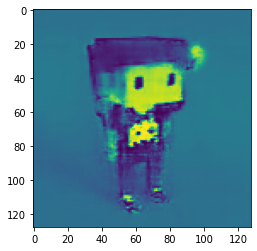

In [52]:
view_sample(GENERATOR, DISCRIMINATOR, SEED_DIM)

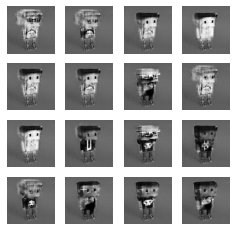

Epoch 45, generator_loss=6.748560428619385,discriminator_loss=0.22600650787353516, run_time=0:01:31.96


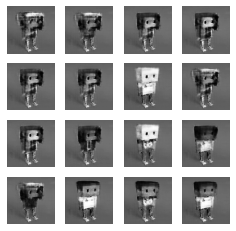

Epoch 46, generator_loss=6.658682823181152,discriminator_loss=0.2862003743648529, run_time=0:01:21.43


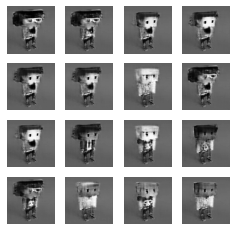

Epoch 47, generator_loss=6.496587753295898,discriminator_loss=0.2534455358982086, run_time=0:01:21.04


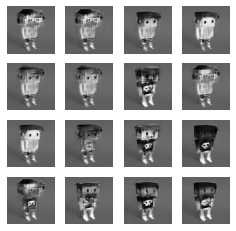

Epoch 48, generator_loss=6.626491069793701,discriminator_loss=0.2649872303009033, run_time=0:01:21.01


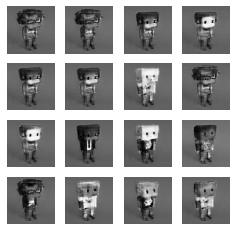

Epoch 49, generator_loss=6.1996049880981445,discriminator_loss=0.2085694521665573, run_time=0:01:21.05


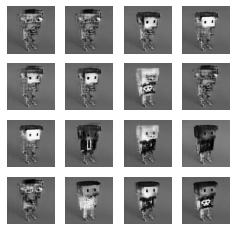

Epoch 50, generator_loss=6.157529354095459,discriminator_loss=0.2558772563934326, run_time=0:01:21.02


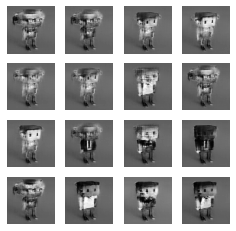

Epoch 51, generator_loss=6.204862117767334,discriminator_loss=0.2962573170661926, run_time=0:01:21.34


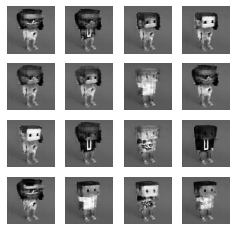

Epoch 52, generator_loss=6.70001745223999,discriminator_loss=0.2622211277484894, run_time=0:01:21.00


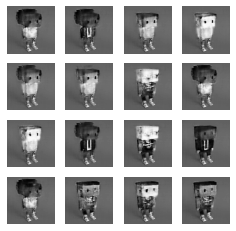

Epoch 53, generator_loss=6.461856842041016,discriminator_loss=0.24418148398399353, run_time=0:01:20.98


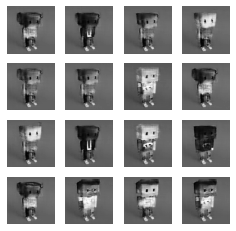

Epoch 54, generator_loss=6.451805591583252,discriminator_loss=0.21233126521110535, run_time=0:01:20.98


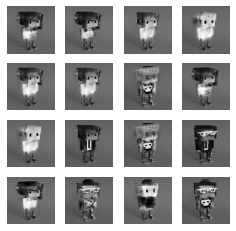

Epoch 55, generator_loss=6.256762504577637,discriminator_loss=0.2661295533180237, run_time=0:01:20.99


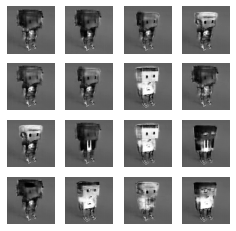

Epoch 56, generator_loss=6.461828231811523,discriminator_loss=0.3229791522026062, run_time=0:01:21.27


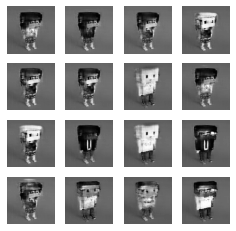

Epoch 57, generator_loss=6.571929454803467,discriminator_loss=0.2604641914367676, run_time=0:01:21.01


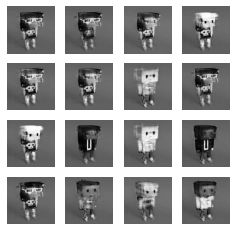

Epoch 58, generator_loss=6.187925338745117,discriminator_loss=0.2079160064458847, run_time=0:01:20.93
INFO:tensorflow:Assets written to: output/meebits-3-19/generator59/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/discriminator59/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/generator/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/discriminator/assets


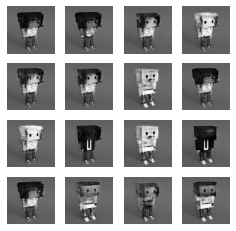

Epoch 59, generator_loss=6.121562957763672,discriminator_loss=0.2273186892271042, run_time=0:01:31.68


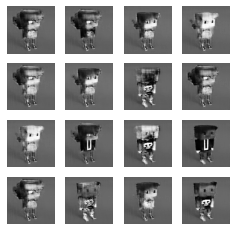

Epoch 60, generator_loss=6.399140357971191,discriminator_loss=0.2630826532840729, run_time=0:01:21.02


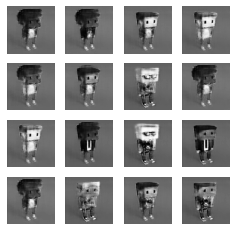

Epoch 61, generator_loss=6.538201808929443,discriminator_loss=0.2625831961631775, run_time=0:01:20.97


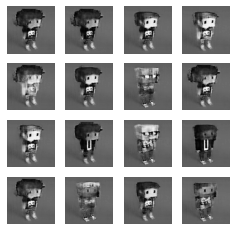

Epoch 62, generator_loss=5.931313514709473,discriminator_loss=0.20114175975322723, run_time=0:01:21.22


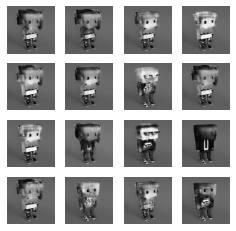

Epoch 63, generator_loss=6.487717628479004,discriminator_loss=0.16960006952285767, run_time=0:01:20.93


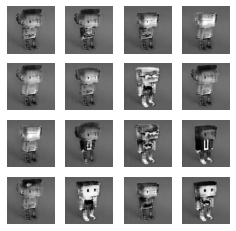

Epoch 64, generator_loss=6.955780029296875,discriminator_loss=0.3347548544406891, run_time=0:01:20.94


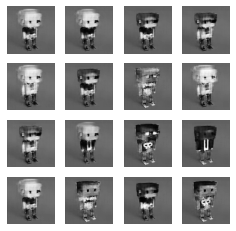

Epoch 65, generator_loss=6.699570178985596,discriminator_loss=0.2609122693538666, run_time=0:01:20.95


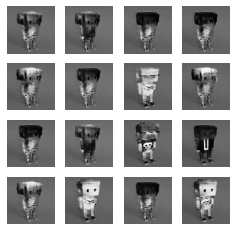

Epoch 66, generator_loss=6.58903694152832,discriminator_loss=0.21268664300441742, run_time=0:01:21.24


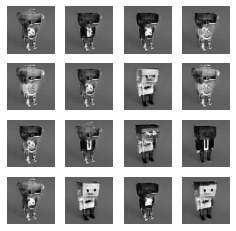

Epoch 67, generator_loss=6.5211710929870605,discriminator_loss=0.18126915395259857, run_time=0:01:20.97


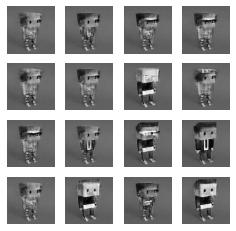

Epoch 68, generator_loss=7.048295021057129,discriminator_loss=0.1800948530435562, run_time=0:01:21.00


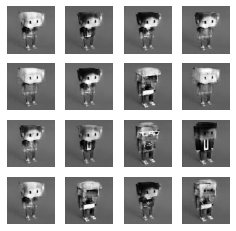

Epoch 69, generator_loss=6.977772235870361,discriminator_loss=0.1368011236190796, run_time=0:01:20.95


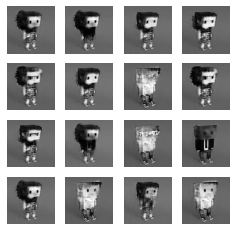

Epoch 70, generator_loss=7.269118785858154,discriminator_loss=0.146951362490654, run_time=0:01:20.96


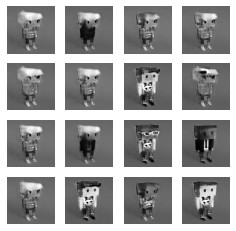

Epoch 71, generator_loss=7.363175868988037,discriminator_loss=0.16976618766784668, run_time=0:01:21.23


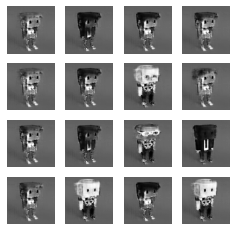

Epoch 72, generator_loss=7.286356449127197,discriminator_loss=0.17097854614257812, run_time=0:01:20.93


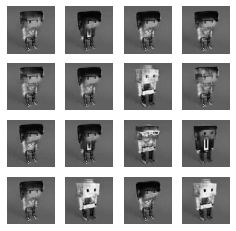

Epoch 73, generator_loss=7.206804275512695,discriminator_loss=0.12253009527921677, run_time=0:01:20.98
INFO:tensorflow:Assets written to: output/meebits-3-19/generator74/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/discriminator74/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/generator/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/discriminator/assets


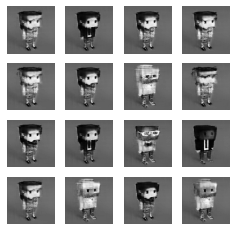

Epoch 74, generator_loss=7.514771938323975,discriminator_loss=0.18863065540790558, run_time=0:01:31.53


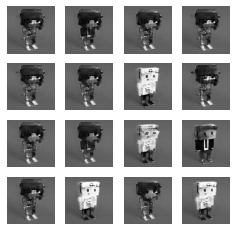

Epoch 75, generator_loss=7.449397563934326,discriminator_loss=0.1769752949476242, run_time=0:01:21.00


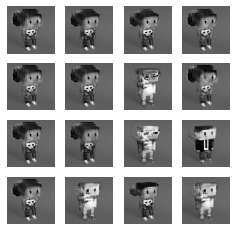

Epoch 76, generator_loss=7.684736251831055,discriminator_loss=0.09948785603046417, run_time=0:01:20.96


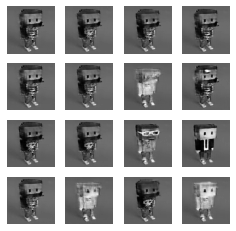

Epoch 77, generator_loss=7.844618797302246,discriminator_loss=0.16206012666225433, run_time=0:01:20.95


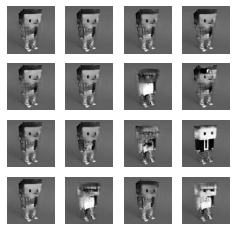

Epoch 78, generator_loss=7.868169784545898,discriminator_loss=0.14803479611873627, run_time=0:01:21.25


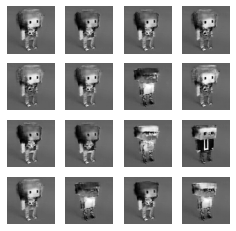

Epoch 79, generator_loss=7.684237957000732,discriminator_loss=0.12313982099294662, run_time=0:01:20.90


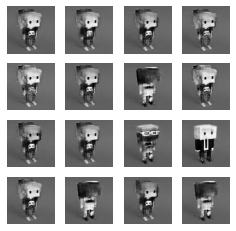

Epoch 80, generator_loss=7.591141700744629,discriminator_loss=0.12361165881156921, run_time=0:01:20.86


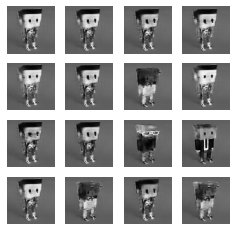

Epoch 81, generator_loss=7.272821426391602,discriminator_loss=0.10717225819826126, run_time=0:01:20.93


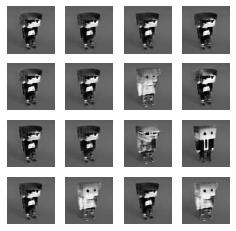

Epoch 82, generator_loss=8.41915512084961,discriminator_loss=0.31061509251594543, run_time=0:01:21.00


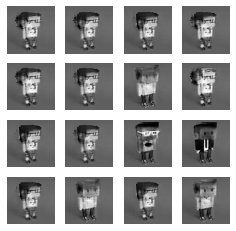

Epoch 83, generator_loss=7.738681316375732,discriminator_loss=0.1161678284406662, run_time=0:01:21.27


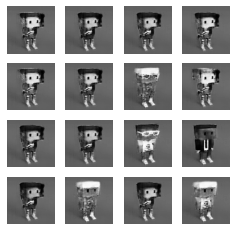

Epoch 84, generator_loss=7.497054576873779,discriminator_loss=0.1291828751564026, run_time=0:01:20.92


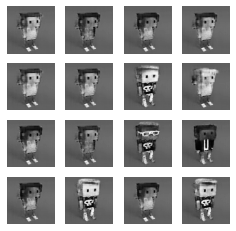

Epoch 85, generator_loss=7.37459135055542,discriminator_loss=0.11959072202444077, run_time=0:01:20.93


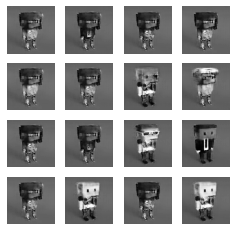

Epoch 86, generator_loss=7.995072364807129,discriminator_loss=0.153647318482399, run_time=0:01:20.94


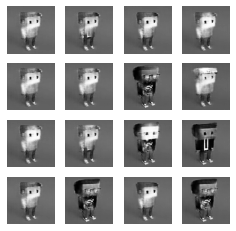

Epoch 87, generator_loss=7.777275085449219,discriminator_loss=0.1363203525543213, run_time=0:01:20.93


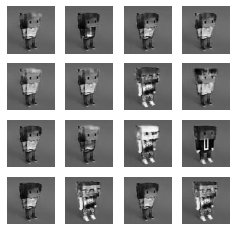

Epoch 88, generator_loss=7.819937705993652,discriminator_loss=0.10922466218471527, run_time=0:01:21.32
INFO:tensorflow:Assets written to: output/meebits-3-19/generator89/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/discriminator89/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/generator/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/discriminator/assets


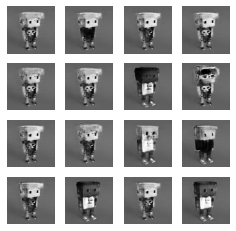

Epoch 89, generator_loss=8.123658180236816,discriminator_loss=0.24448652565479279, run_time=0:01:31.18


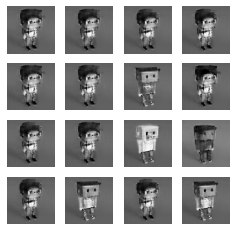

Epoch 90, generator_loss=7.879426002502441,discriminator_loss=0.09825211763381958, run_time=0:01:21.28


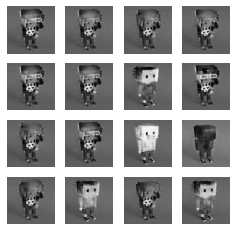

Epoch 91, generator_loss=8.687935829162598,discriminator_loss=0.09768172353506088, run_time=0:01:20.96


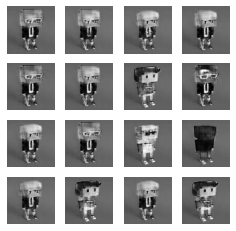

Epoch 92, generator_loss=8.013904571533203,discriminator_loss=0.07505084574222565, run_time=0:01:20.98


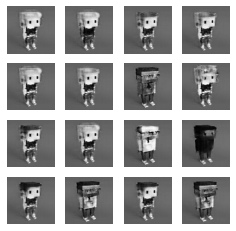

Epoch 93, generator_loss=8.008628845214844,discriminator_loss=0.08752280473709106, run_time=0:01:20.95


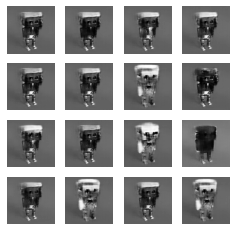

Epoch 94, generator_loss=8.962408065795898,discriminator_loss=0.29613128304481506, run_time=0:01:20.89


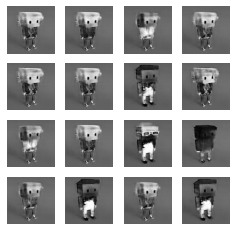

Epoch 95, generator_loss=7.682592868804932,discriminator_loss=0.10337124764919281, run_time=0:01:21.26


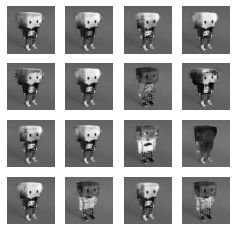

Epoch 96, generator_loss=7.538181781768799,discriminator_loss=0.10045260936021805, run_time=0:01:20.93


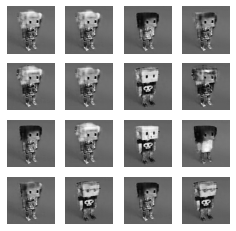

Epoch 97, generator_loss=8.038622856140137,discriminator_loss=0.10751844942569733, run_time=0:01:21.00


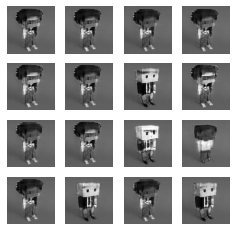

Epoch 98, generator_loss=8.295065879821777,discriminator_loss=0.09742587059736252, run_time=0:01:20.93


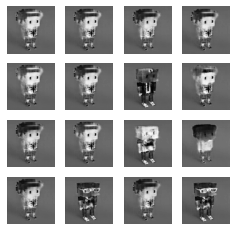

Epoch 99, generator_loss=8.51828384399414,discriminator_loss=0.10492073744535446, run_time=0:01:20.96


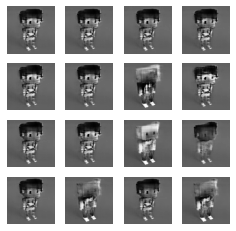

Epoch 100, generator_loss=9.977401733398438,discriminator_loss=0.28293177485466003, run_time=0:01:21.20


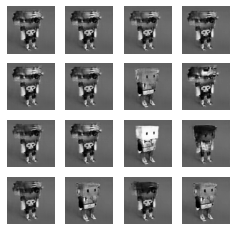

Epoch 101, generator_loss=8.353048324584961,discriminator_loss=0.0750957801938057, run_time=0:01:20.93


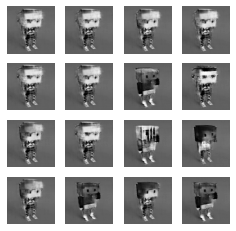

Epoch 102, generator_loss=8.424346923828125,discriminator_loss=0.06895121932029724, run_time=0:01:20.89


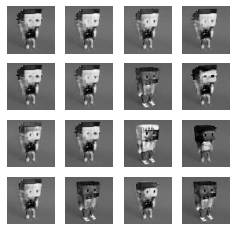

Epoch 103, generator_loss=8.508098602294922,discriminator_loss=0.06549423187971115, run_time=0:01:20.92
INFO:tensorflow:Assets written to: output/meebits-3-19/generator104/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/discriminator104/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/generator/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/discriminator/assets


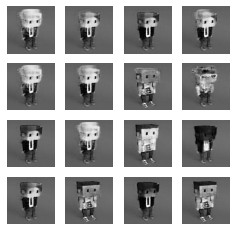

Epoch 104, generator_loss=8.307215690612793,discriminator_loss=0.058734580874443054, run_time=0:01:31.16


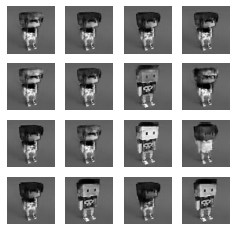

Epoch 105, generator_loss=8.97885513305664,discriminator_loss=0.13213613629341125, run_time=0:01:20.97


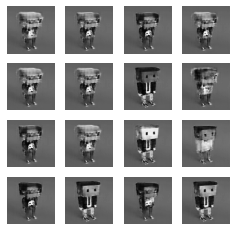

Epoch 106, generator_loss=9.150178909301758,discriminator_loss=0.13640937209129333, run_time=0:01:20.93


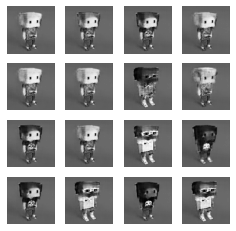

Epoch 107, generator_loss=8.546606063842773,discriminator_loss=0.08627811074256897, run_time=0:01:21.27


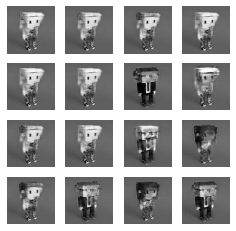

Epoch 108, generator_loss=8.541868209838867,discriminator_loss=0.08344164490699768, run_time=0:01:20.89


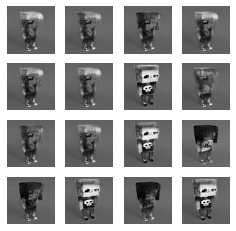

Epoch 109, generator_loss=10.145613670349121,discriminator_loss=0.15080785751342773, run_time=0:01:20.91


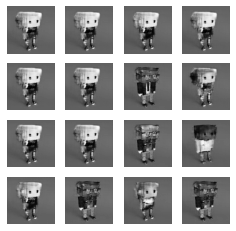

Epoch 110, generator_loss=8.263167381286621,discriminator_loss=0.09798622131347656, run_time=0:01:21.00


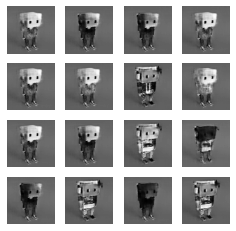

Epoch 111, generator_loss=8.55994987487793,discriminator_loss=0.08664420992136002, run_time=0:01:21.24


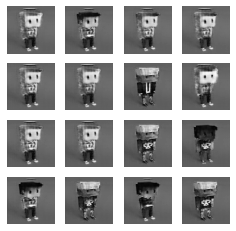

Epoch 112, generator_loss=8.155624389648438,discriminator_loss=0.06851505488157272, run_time=0:01:20.93


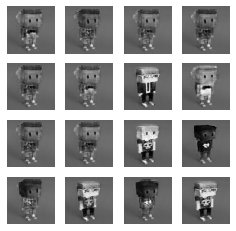

Epoch 113, generator_loss=8.671086311340332,discriminator_loss=0.1172824278473854, run_time=0:01:20.98


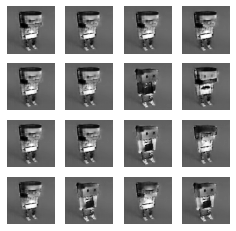

Epoch 114, generator_loss=9.207050323486328,discriminator_loss=0.05632999166846275, run_time=0:01:20.93


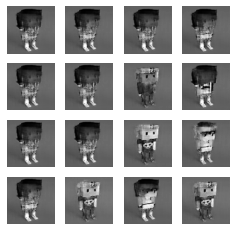

Epoch 115, generator_loss=9.197168350219727,discriminator_loss=0.07441088557243347, run_time=0:01:20.99


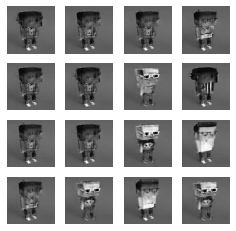

Epoch 116, generator_loss=9.575322151184082,discriminator_loss=0.07027383148670197, run_time=0:01:21.24


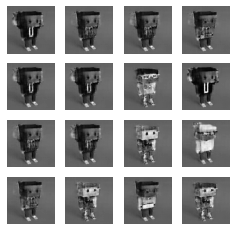

Epoch 117, generator_loss=9.440415382385254,discriminator_loss=0.3071720600128174, run_time=0:01:20.91


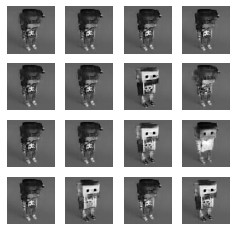

Epoch 118, generator_loss=8.283363342285156,discriminator_loss=0.1278722584247589, run_time=0:01:20.95
INFO:tensorflow:Assets written to: output/meebits-3-19/generator119/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/discriminator119/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/generator/assets
INFO:tensorflow:Assets written to: output/meebits-3-19/discriminator/assets


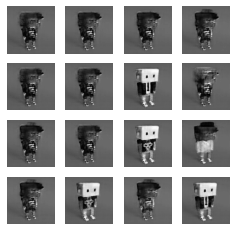

Epoch 119, generator_loss=8.448753356933594,discriminator_loss=0.08800611644983292, run_time=0:01:31.22


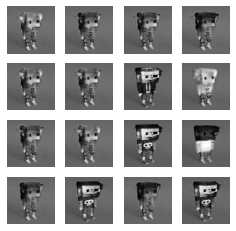

Epoch 120, generator_loss=8.277527809143066,discriminator_loss=0.0922572910785675, run_time=0:01:20.94


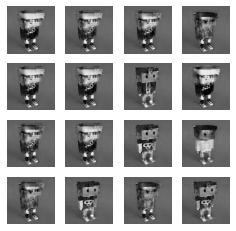

Epoch 121, generator_loss=8.845755577087402,discriminator_loss=0.2645474076271057, run_time=0:01:20.93


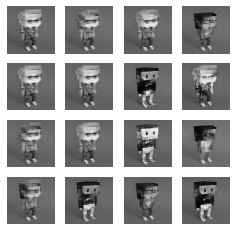

Epoch 122, generator_loss=8.318419456481934,discriminator_loss=0.06517458707094193, run_time=0:01:21.01


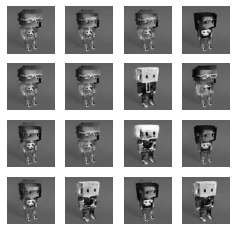

Epoch 123, generator_loss=8.333695411682129,discriminator_loss=0.07526304572820663, run_time=0:01:21.28


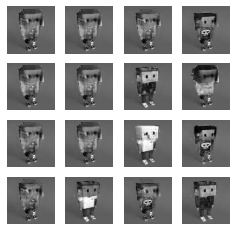

Epoch 124, generator_loss=8.225341796875,discriminator_loss=0.07674993574619293, run_time=0:01:20.99


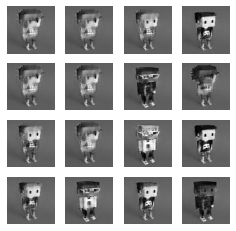

Epoch 125, generator_loss=8.743170738220215,discriminator_loss=0.07696759700775146, run_time=0:01:20.95


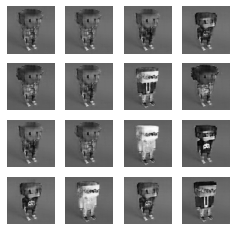

Epoch 126, generator_loss=8.931360244750977,discriminator_loss=0.05552645027637482, run_time=0:01:21.04


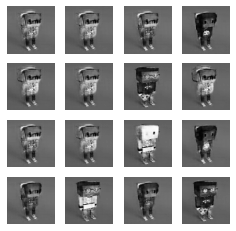

Epoch 127, generator_loss=9.901871681213379,discriminator_loss=0.07075267285108566, run_time=0:01:21.05


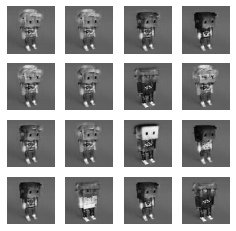

Epoch 128, generator_loss=9.50550365447998,discriminator_loss=0.08445164561271667, run_time=0:01:21.36


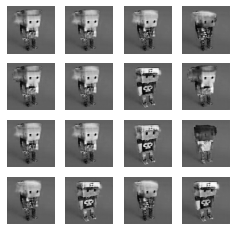

Epoch 129, generator_loss=9.79464340209961,discriminator_loss=0.14177162945270538, run_time=0:01:21.02


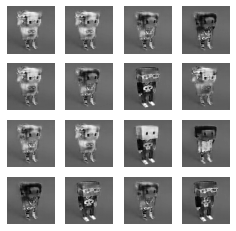

Epoch 130, generator_loss=9.064241409301758,discriminator_loss=0.1370547115802765, run_time=0:01:21.01


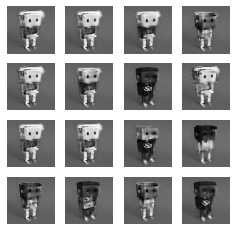

Epoch 131, generator_loss=8.798908233642578,discriminator_loss=0.07363337278366089, run_time=0:01:21.03


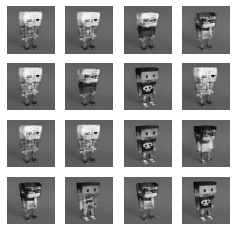

Epoch 132, generator_loss=8.667339324951172,discriminator_loss=0.06488246470689774, run_time=0:01:21.02


In [ ]:
# start/continue training
train(train_dataset, startepoch, EPOCHS, BATCH_SIZE, OUTPUT_PATH)

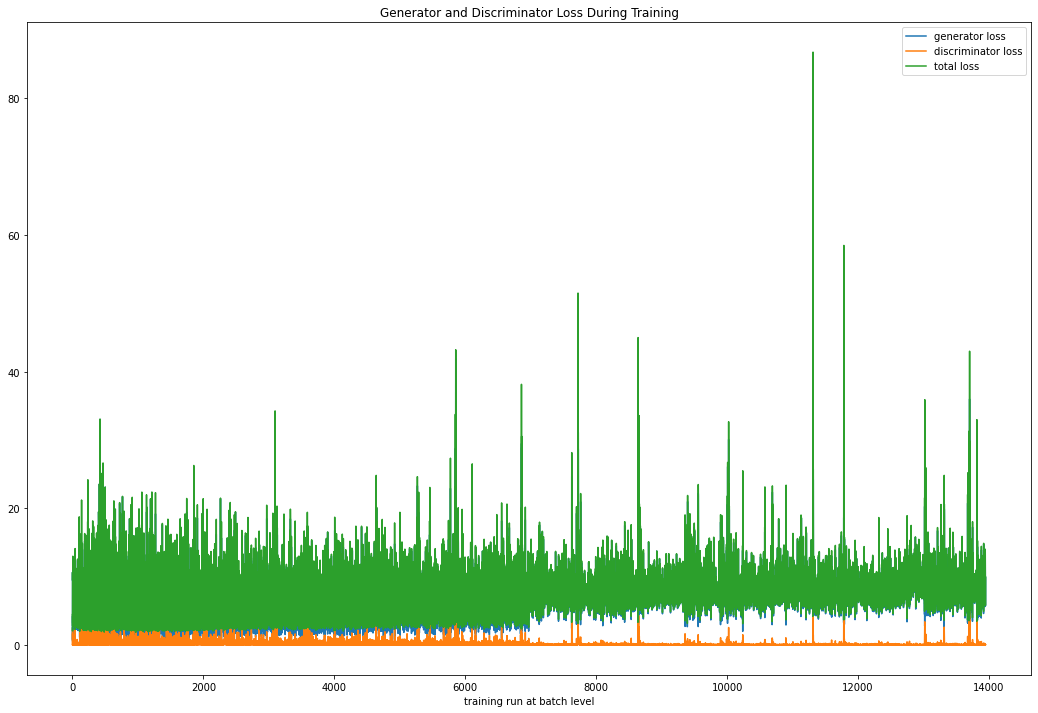

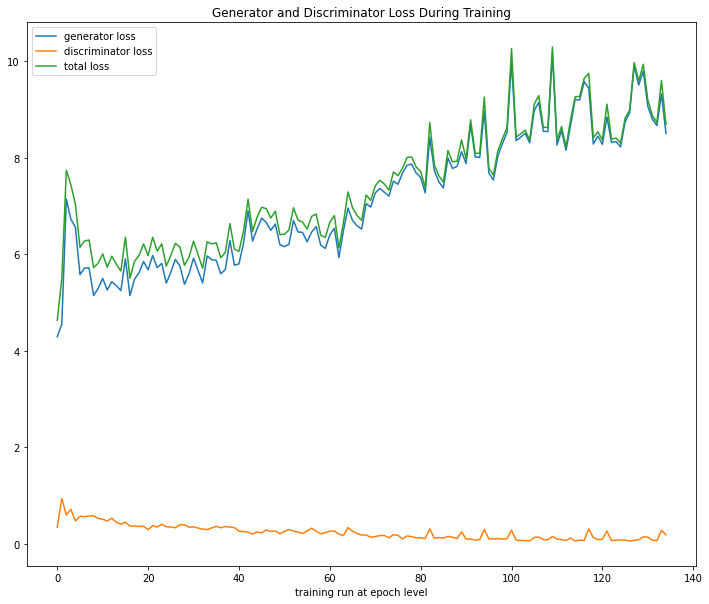

In [43]:
# display training loss metrics, both batch and epoch level
loss_metics_chart('batch', None, 'output/meebits-3-19/')
loss_metics_chart('epoch', None, 'output/meebits-3-19/')